## This assignment is designed for automated pathology detection for Medical Images in a relalistic setup, i.e. each image may have multiple pathologies/disorders. 
### The goal, for you as an MLE, is to design models and methods to predictively detect pathological images and explain the pathology sites in the image data.

## Data for this assignment is taken from a Kaggle contest: https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview
Explanation of the data set:
The training data set contains 3435 retinal images that represent multiple pathological disorders. The patholgy classes and corresponding labels are: included in 'train.csv' file and each image can have more than one class category (multiple pathologies).
The labels for each image are

```
-opacity (0), 
-diabetic retinopathy (1), 
-glaucoma (2),
-macular edema (3),
-macular degeneration (4),
-retinal vascular occlusion (5)
-normal (6)
```
The test data set contains 350 unlabelled images.

## Task 2: Visualize the heatmap/saliency/features using any method of your choice to demonstrate what regions of interest contribute to Diabetic Retinopathy and Glaucoma, respectively. (25 points)
```
Submit images/folder of images with heatmaps/features aligned on top of the images, or corresponding bounding boxes, and report what regions of interest in your opinion represent the pathological sites.
```

# Task 2: Create Heatmaps

In [1]:
# importing the required modules
import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageEnhance
import os
import shutil

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import gradients, mean

from sklearn.model_selection import train_test_split

In [2]:
# find path for the data
data_path = 'Data'

### Create Data Pipelines

In [3]:
# direcotries containing files
normal_dir = 'Data/separated_pics_train/normal'
glaucoma_dir = 'Data/separated_pics_train/glaucoma'
dbr_dir = 'Data/separated_pics_train/diabetic retinopathy'
other_dir = 'Data/separated_pics_train/other'

## Creating Saliency Maps

The problem with creating saliency maps with the custom architecture is that the preloaded model appears as a functional layer. The sublayers in this functional model cannot be called directly. As a result the model gives a "Graph Disconnected" error. However, with this custom model it is possible to call any layer without an issue.

In [3]:
# use this cell if loading a pre-trained model
model_pretrained = tf.keras.models.load_model('models/dbr_v1.h5')
model_pretrained.trainable = False
model_pretrained.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 222, 222, 256 7168        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 111, 111, 256 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 109, 109, 256 590080      max_pooling2d_8[0][0]            
_______________________________________________________________________________________

In [4]:
# define image size and channels
IMAGE_SIZE = 224
CHANNELS = 3

BATCH_SIZE = 64

In [5]:
# increasing contrast and brightness
def contrast(img_np):
    img = tf.image.adjust_contrast(img_np, 2)
    img = tf.image.adjust_brightness(img, 0.5)
    return img

### Create model

Skipping the final activation layer and just getting the logits as these will be used for the final part of the assignment

In [64]:
# define the classifier layer that will be used to calculate the output
classifier_layers = ['global_average_pooling2d_7', 'dense_6']

In [6]:
# get list of examples to create the heatmaps
img_path_list = os.listdir('category _examples')

In [7]:
# function to load images to numpy array and normalize
def img_to_np(img_path):
    # open image using PIL
    img_temp = Image.open(img_path)
    img_temp = img_temp.resize((IMAGE_SIZE,IMAGE_SIZE), resample=1)

    # convert to np array
    img_temp = np.array(img_temp).astype(np.float32)
    img_temp = img_temp/255.0
    
    return img_temp

In [8]:
# function to cover image with heat map
def cover_img(img_path, heatmap):
    # Use cv2 to load the original image
    img_original = cv2.imread(img_path)

    # set the intensity map at 0.5
    INTENSITY = 0.5

    # Resize the heatmap to have the same size as the original image
    heatmap_resized = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))

    # Convert the heatmap to RGB
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # We apply the heatmap to the original image
    heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # processed image
    img_new = heatmap_resized * INTENSITY + img_original

    return img_new

### Get Gradient on Images
Finally test the functions on all images. We will also save all the bounding boxes with the file names in a dict.

In [9]:
# import needed modules
from tensorflow import GradientTape

In [10]:
# last conv layer of the base model
last_conv_layer_1 = 'conv2d_11'

category _examples/normal2.jpg


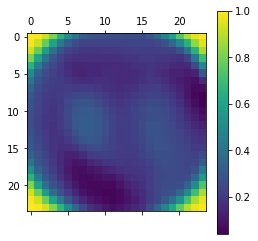

category _examples/glc1.jpg


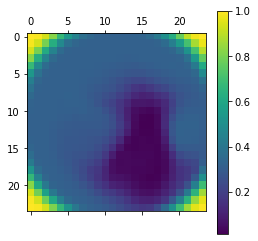

category _examples/dbr1.jpg


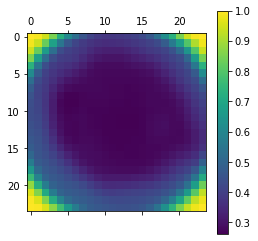

category _examples/glc2.jpg


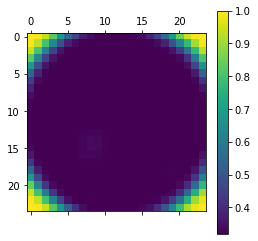

category _examples/normal1.jpg


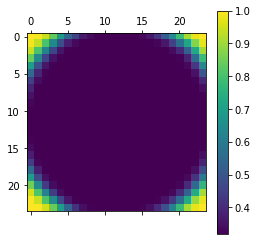

category _examples/dbr2.jpg


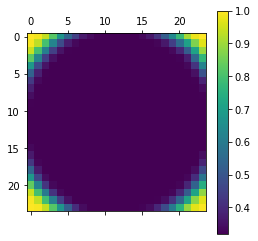

In [16]:
# plot gradient map
for pic in img_path_list:
    pic_path = os.path.join('category _examples', pic)
    print(pic_path)
  
    # load each image to pass to model to make predictions
    img_temp = img_to_np(pic_path)
    preds = model_pretrained.predict(np.expand_dims(img_temp, axis=0))

    # creating heat maps
    with GradientTape() as tape:
        # getting the last conv layer of the model, might have to change this to a layer above
        last_conv_layer = model_pretrained.get_layer('conv2d_11')

        # iterate will allow us to access the values of the quatities defined below i.e.
        # pooled_grads and the outputs of the last conv layer
        iterate = tf.keras.models.Model([model_pretrained.inputs], 
                                        [model_pretrained.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(np.expand_dims(img_temp, axis=0))
        class_out = model_out[:, np.argmax(model_out[0])]

        # calculate teh gradients of the class wrt to last layer
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = mean(grads, axis=(0, 1, 2))

        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

    # plot original heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # the reshape value will very if a different model is used since the shape 
    # depends on the output of the final conv layer, so make changes accordingly
    heatmap = heatmap.reshape((24, 24))
    plt.matshow(heatmap)
    plt.colorbar()
    plt.show()

    # save image with heatmap cover
    #plt.imshow(cover_img(img_path, htmp), cmap='gray', interpolation='bicubic')
    cv2.imwrite(os.path.join('img_heatmap', pic), cover_img(pic_path, heatmap))

## Overlain images
<img src="img_heatmap/dbr1.jpg" alt="diabetic retinopathy" width="200"/>
<img src="img_heatmap/dbr2.jpg" alt="diabetic retinopathy" width="200"/>
<img src="img_heatmap/normal1.jpg" alt="normal" width="200"/>
<img src="img_heatmap/normal2.jpg" alt="normal" width="200"/>